In [1]:
import os
import json
import torch
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [2]:
BASE_DIR = "/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset/ArTaxOr"
IMAGE_EXTENSIONS = ['.jpg', '.jpeg', '.png']
class_mapping = {
    'Araneae': 0, 
    'Coleoptera': 1,
    'Diptera': 2,
    'Hemiptera': 3,
    'Hymenoptera': 4,
    'Lepidoptera': 5,
    'Odonata': 6
}

In [3]:
def parse_json_annotation(json_file, class_label):
    """Parse regions and bounding boxes from JSON file."""
    with open(json_file, 'r') as f:
        data = json.load(f)    
    regions = data.get('regions', [])
    boxes = []
    labels = []
    for region in regions:
        x_min = region['x']
        y_min = region['y']
        x_max = x_min + region['width']
        y_max = y_min + region['height']
        boxes.append([x_min, y_min, x_max, y_max])
        labels.append(class_mapping[class_label])  
    return boxes, labels

In [4]:
def get_image_and_annotation_paths(base_dir):
    """
    Collect image and annotation paths by extracting the 'name' field 
    from the annotation JSON and matching it to the actual image files.
    """
    image_paths = []
    annotation_paths = []
    class_labels = []   
    image_extensions = ['.jpg', '.jpeg', '.png']
    available_images = {}
    for root, _, files in os.walk(base_dir):
        for file in files:
            if any(file.endswith(ext) for ext in image_extensions):
                available_images[file] = os.path.join(root, file)  # Store full path
    for root, dirs, files in os.walk(base_dir):
        for folder in dirs:
            if folder in class_mapping: 
                annotation_folder = os.path.join(root, folder, "annotations")
                
                for file in os.listdir(annotation_folder):
                    if file.endswith('.json'):
                        json_path = os.path.join(annotation_folder, file)
                        
                        # Parse JSON to extract image name
                        with open(json_path, 'r') as f:
                            data = json.load(f)
                            image_name = data['asset']['name']  # Extract image filename
                        
                        # Match extracted image name to available images
                        if image_name in available_images:
                            image_paths.append(available_images[image_name])
                            annotation_paths.append(json_path)
                            class_labels.append(folder)
                        else:
                            print(f"Warning: No image found for annotation {file}")
    
    return image_paths, annotation_paths, class_labels


In [5]:
class ArTaxOrDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, transforms=None):
        self.image_paths, self.annotation_paths, self.class_labels = get_image_and_annotation_paths(base_dir)
        self.transforms = transforms
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert("RGB")
        
        # Load annotation
        json_path = self.annotation_paths[idx]
        with open(json_path, 'r') as f:
            data = json.load(f)
        
        # Parse bounding boxes and labels
        boxes = []
        labels = []
        for region in data['regions']:
            bbox = region['boundingBox']
            left, top, width, height = bbox['left'], bbox['top'], bbox['width'], bbox['height']
            boxes.append([left, top, left + width, top + height])
            
            # Use the first tag as the label
            label = region['tags'][0]
            labels.append(class_mapping[label])
        
        # Convert to tensors
        target = {
            'boxes': torch.as_tensor(boxes, dtype=torch.float32),
            'labels': torch.as_tensor(labels, dtype=torch.int64)
        }
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, target

In [6]:
base_dir = '/kaggle/input/arthropod-taxonomy-orders-object-detection-dataset'
dataset = ArTaxOrDataset(base_dir)

# Fetch first item
image, target = dataset[0]
print("Image size:", image.size)
print("Bounding Boxes:", target['boxes'])
print("Labels:", target['labels'])

Image size: (3486, 2324)
Bounding Boxes: tensor([[1508.7581,  465.4534, 2332.8091, 1135.9767]])
Labels: tensor([1])


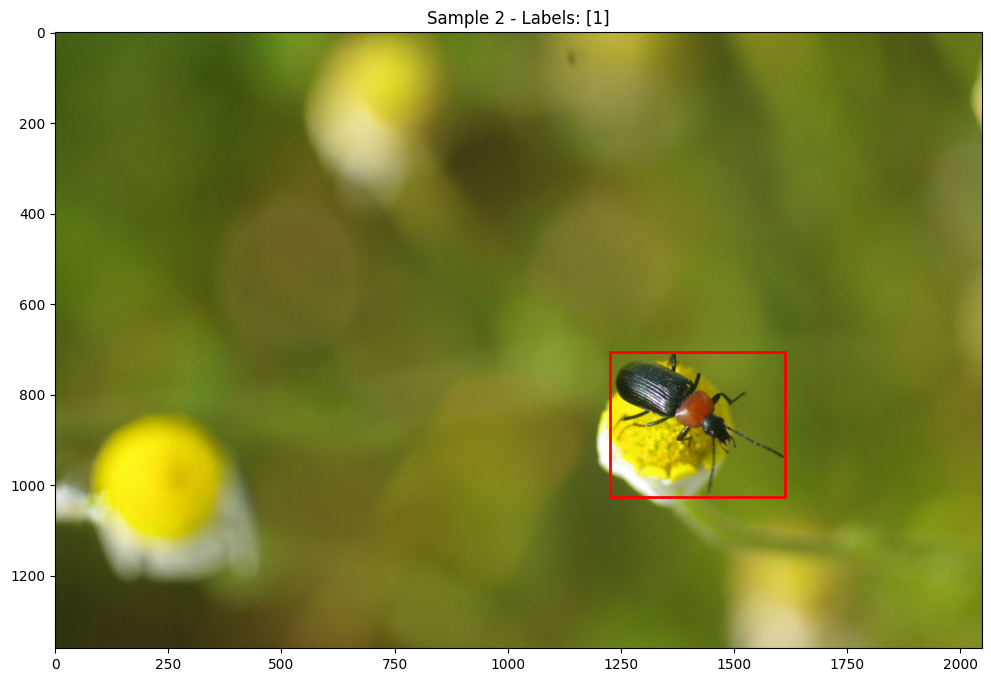

In [7]:
def visualize_sample(dataset, idx):
    image, target = dataset[idx]
    fig, ax = plt.subplots(1, figsize=(12, 8))
    
    # Convert image to displayable format
    ax.imshow(image)
    
    # Draw bounding boxes
    for box in target['boxes']:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    
    plt.title(f"Sample {idx} - Labels: {target['labels'].tolist()}")
    plt.show()

# Test visualization
visualize_sample(dataset, 2)


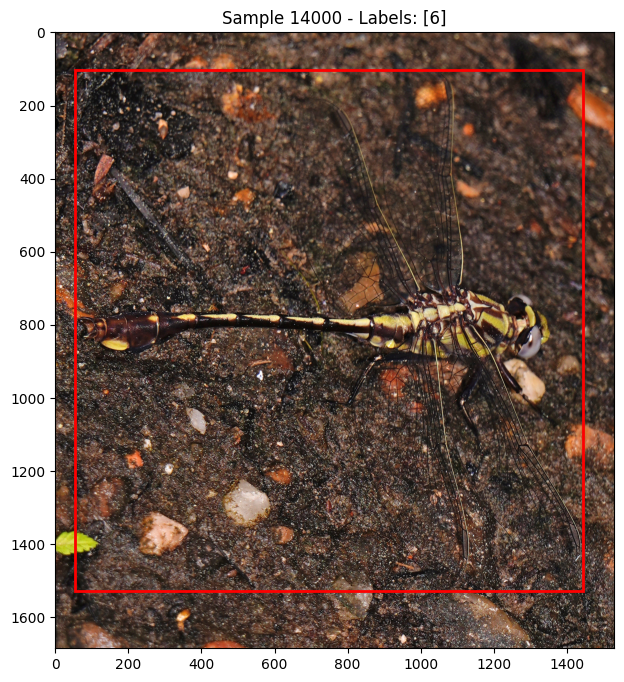

In [8]:
visualize_sample(dataset, 14000)